In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', as_frame = False)# we are setting as_frame = False because the open_ml function by default returns the inputs as a Pandas DataFrame and labels as Pandas Series. But the MNIST dataset contains images and DataFrames aren't ideal for that.

In [3]:
X, y = mnist.data, mnist.target

In [4]:
X.shape #70000 images, and each image has 784 features(because each image is 28 x 28 pixels)

(70000, 784)

#### Each feature simply represents one pixel's intensity from 0(white) to 255(black)

In [5]:
y.shape

(70000,)

#### Now, we need to grab an instance's feature vector, reshape it to a 28 x 28 array, and display it using Matplotlib's imshow() function. We use cmap = "binary" to get a greyscale color map where 0 is white and 255 is black

In [6]:
import matplotlib.pyplot as plt

In [7]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

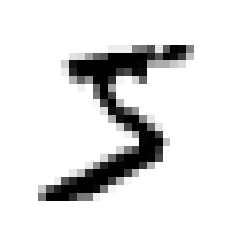

In [8]:
some_digit = X[0]
plot_digit(some_digit)
#plt.show()

In [9]:
y[0]

'5'

#### Now we create training set and testing set to inspect data closely

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### We will train a Binary Classifier now and take 2 target vectors for this classification - 5 and non-5

In [11]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

#### We use Stochastic Gradient Descent Classifier (SGDClassifier) for binary classification here

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

In [14]:
from sklearn.model_selection import cross_val_score

In [15]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")#output will be an array of accuracy scores, one for each fold of the cross-validation.(accuracy is not a good to evaluate the performance of a classifier)

array([0.87365, 0.85835, 0.8689 ])

#### Implementing cross_val_score on StratifiedKFold

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [17]:
skfolds = StratifiedKFold(n_splits = 3)

In [18]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


#### Computing the confusion matrix

In [19]:
from sklearn.model_selection import cross_val_predict 

In [20]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [23]:
from sklearn.metrics import precision_score, recall_score

In [24]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [25]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [26]:
from sklearn.metrics import f1_score

In [27]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [28]:
y_scores = sgd_clf.decision_function([some_digit])

In [29]:
y_scores

array([2164.22030239])

In [47]:
threshold = 4000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False, False, False, ...,  True, False, False])

In [48]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

In [51]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

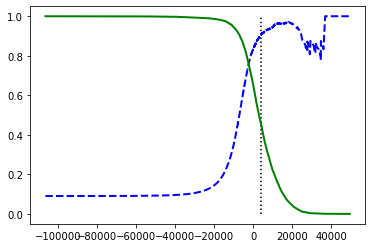

In [52]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

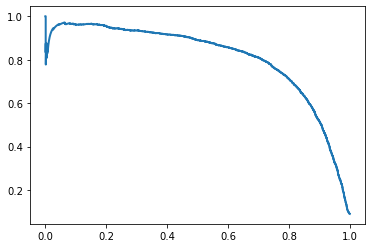

In [53]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.show()

In [54]:
idx_for_90_precision = (precisions >= .90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439594

In [56]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [57]:
precision_score(y_train_5, y_train_pred_90)
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

In [59]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

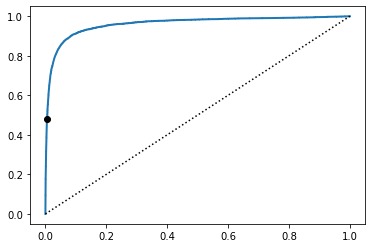

In [63]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0,1], [0,1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshodl for 90% precision")
plt.show()

In [64]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

#### Use a PR-curve when you care more about the false postive than the false negatives. Otherwise, use the ROC curve

In [65]:
 from sklearn.ensemble import RandomForestClassifier

In [66]:
forest_clf = RandomForestClassifier(random_state=42)

In [69]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [70]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [71]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

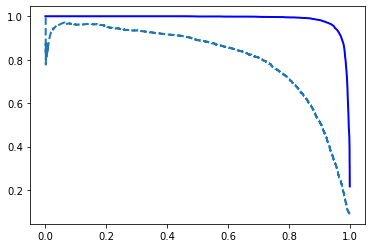

In [73]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.show()

In [78]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [79]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145